# Análise Exploratória e Mining de Dados - Jogos Olímpicos
**Grupo:** G03 | **Unidade Curricular:** IA25

## Objetivos
1. **EDA:** Análise demográfica e temporal dos atletas.
2. **Feature Engineering:** Preparação para regressão (Previsão de Medalhas).
3. **Association Rules:** Identificar padrões de sucesso entre medalhados usando o algoritmo Apriori.

In [ ]:
# Instalação de bibliotecas (incluindo mlxtend para regras de associação)
%pip install pandas numpy matplotlib seaborn mlxtend

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

# Configuração estética
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 6)

Note: you may need to restart the kernel to use updated packages.


In [ ]:
try:
    df = pd.read_csv("athlete_events.csv")
    print(f"Dataset carregado! Dimensões: {df.shape}")
except FileNotFoundError:
    print("ERRO: Ficheiro 'athlete_events.csv' não encontrado.")

Dataset carregado! Dimensões: (271116, 15)


## 1. Feature Engineering e Visualização Temporal
Agrupamento por décadas para reduzir ruído.

C:\Users\bill_\AppData\Local\Temp\ipykernel_31508\2496730039.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Decade", data=df, palette="viridis")


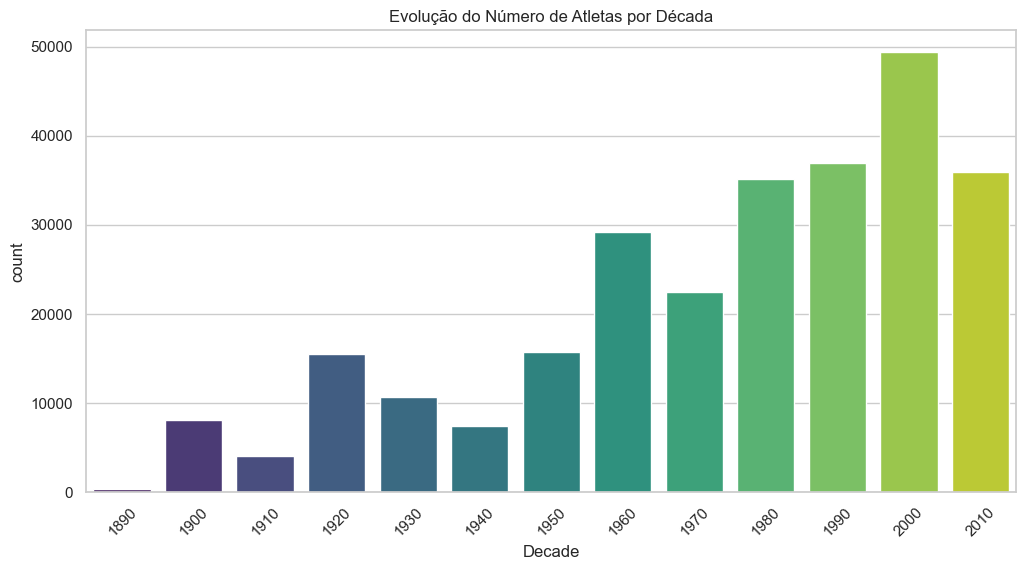

In [ ]:
df['Decade'] = (df['Year'] // 10) * 10

plt.figure(figsize=(12, 6))
sns.countplot(x="Decade", data=df, palette="viridis")
plt.title("Evolução do Número de Atletas por Década")
plt.xticks(rotation=45)
plt.show()

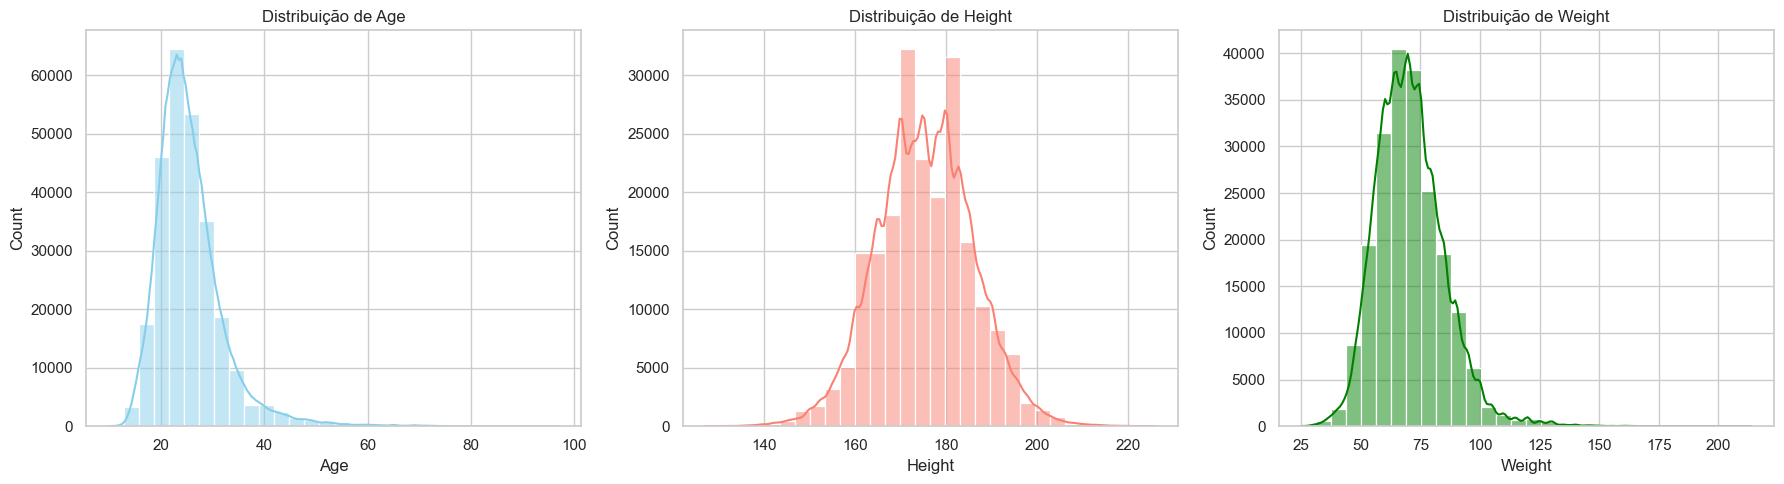

In [ ]:
# Distribuição de Atributos Físicos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cols = ['Age', 'Height', 'Weight']
colors = ['skyblue', 'salmon', 'green']

for i, col in enumerate(cols):
    sns.histplot(df[col].dropna(), bins=30, kde=True, ax=axes[i], color=colors[i])
    axes[i].set_title(f'Distribuição de {col}')

plt.tight_layout()
plt.show()

## 2. Preparação para Machine Learning (Regressão)
Criação de dataset agregado para prever medalhas por país.

,NOC,Year,Decade,Medal_Count
0,AFG,2008,2000,1
1,AFG,2012,2010,1
2,AHO,1988,1980,1
3,ALG,1984,1980,2
4,ALG,1992,1990,2


C:\Users\bill_\AppData\Local\Temp\ipykernel_31508\916486226.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=subset_top, x='Decade', y='Medal_Count', hue='NOC', marker='o', ci=None)


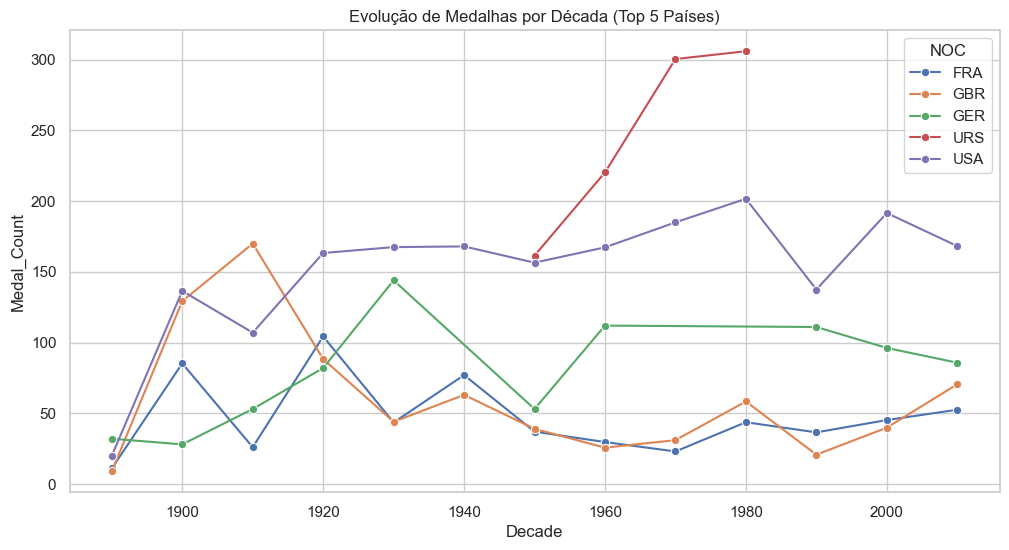

In [ ]:
medals_only = df.dropna(subset=['Medal'])
country_performance = medals_only.groupby(['NOC', 'Year', 'Decade'])['Medal'].count().reset_index()
country_performance.rename(columns={'Medal': 'Medal_Count'}, inplace=True)

display(country_performance.head())

# Top 5 Países
top_countries = country_performance.groupby('NOC')['Medal_Count'].sum().nlargest(5).index
subset_top = country_performance[country_performance['NOC'].isin(top_countries)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=subset_top, x='Decade', y='Medal_Count', hue='NOC', marker='o', ci=None)
plt.title("Evolução de Medalhas por Década (Top 5 Países)")
plt.show()

# 3. Association Rules (Regras de Associação)

## 3.1 Objetivo de Negócio
O objetivo é **descobrir padrões frequentes entre os atletas medalhados**. 
Queremos responder a perguntas como: 
*"Existem combinações específicas de idade, sexo e desporto que ocorrem frequentemente juntas no pódio?"*

Isto pode ajudar federações a identificar perfis de sucesso.

## 3.2 Preparação de Dados
O algoritmo Apriori exige dados categóricos (transações). Faremos o seguinte:
1.  **Filtragem:** Focar apenas em atletas que ganharam medalhas (o nosso "cesto" de interesse).
2.  **Discretização:** Transformar a variável numérica `Age` em categorias (`Age_Bin`).
3.  **Seleção:** Usar colunas relevantes: `Sex`, `Season`, `Medal`, `Age_Bin`.
4.  **One-Hot Encoding:** Converter para formato binário.

In [ ]:
# 1. Filtrar apenas medalhados (ignoramos quem não ganhou nada para esta análise)
df_medals = df.dropna(subset=['Medal']).copy()

# 2. Discretizar Idade (Binning)
# Definir intervalos: <20 (Teen), 20-30 (Young Adult), 30-40 (Adult), >40 (Veteran)
bins = [0, 20, 30, 40, 100]
labels = ['Teen', 'Young Adult', 'Adult', 'Veteran']
df_medals['Age_Bin'] = pd.cut(df_medals['Age'], bins=bins, labels=labels)

# 3. Selecionar colunas de interesse
# Nota: Não incluímos 'Sport' ou 'NOC' aqui para evitar gerar milhares de colunas, 
# mas poderíamos incluir se quiséssemos regras específicas por desporto.
subset_cols = ['Sex', 'Season', 'Medal', 'Age_Bin']
transactions = df_medals[subset_cols].dropna()

# 4. One-Hot Encoding (Formato necessário para Apriori)
basket = pd.get_dummies(transactions)

# Converter para boolean (True/False) para economizar memória e cumprir requisitos do mlxtend recente
basket = basket.astype(bool)

print("Formato dos dados para Apriori:")
display(basket.head())

Formato dos dados para Apriori:


,Sex_F,Sex_M,Season_Summer,Season_Winter,Medal_Bronze,Medal_Gold,Medal_Silver,Age_Bin_Teen,Age_Bin_Young Adult,Age_Bin_Adult,Age_Bin_Veteran
3,False,True,True,False,False,True,False,False,False,True,False
37,False,True,True,False,True,False,False,False,True,False,False
38,False,True,True,False,True,False,False,False,True,False,False
40,False,True,False,True,True,False,False,False,True,False,False
41,False,True,True,False,True,False,False,False,True,False,False


## 3.3 Aplicação do Algoritmo Apriori
Vamos gerar *itemsets* frequentes com um suporte mínimo de 5% (min_support=0.05).

In [ ]:
# Gerar itemsets frequentes
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)

# Ordenar por suporte para ver o que é mais comum
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

print("Top 10 Itemsets mais frequentes:")
display(frequent_itemsets.head(10))

Top 10 Itemsets mais frequentes:


,support,itemsets
2,0.854447,(Season_Summer)
1,0.712274,(Sex_M)
8,0.694989,(Age_Bin_Young Adult)
16,0.613096,"(Season_Summer, Sex_M)"
28,0.588103,"(Age_Bin_Young Adult, Season_Summer)"
22,0.504008,"(Age_Bin_Young Adult, Sex_M)"
46,0.429592,"(Season_Summer, Age_Bin_Young Adult, Sex_M)"
5,0.338634,(Medal_Gold)
4,0.333052,(Medal_Bronze)
6,0.328314,(Medal_Silver)


## 3.4 Geração e Avaliação de Regras
Geramos as regras de associação baseadas na métrica **Lift**.
- **Lift > 1:** Indica uma associação positiva (A e B ocorrem juntos mais do que o esperado ao acaso).
- **Confidence:** A probabilidade de B acontecer dado que A aconteceu.

In [ ]:
# Gerar regras
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Filtrar para regras interessantes (Confiança > 50%)
interesting_rules = rules[rules['confidence'] > 0.5].sort_values(by='lift', ascending=False)

print(f"Foram encontradas {len(interesting_rules)} regras interessantes.")

# Mostrar colunas principais
cols_show = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
display(interesting_rules[cols_show].head(10))

Foram encontradas 53 regras interessantes.


,antecedents,consequents,support,confidence,lift
93,"(Season_Summer, Age_Bin_Adult)",(Sex_M),0.093493,0.790089,1.109249
85,(Age_Bin_Adult),(Sex_M),0.109293,0.779686,1.094644
97,(Age_Bin_Adult),"(Season_Summer, Sex_M)",0.093493,0.666971,1.087874
103,"(Sex_M, Season_Winter)",(Age_Bin_Young Adult),0.074416,0.750323,1.079619
87,(Season_Winter),(Age_Bin_Young Adult),0.106886,0.734342,1.056625
106,"(Age_Bin_Teen, Sex_M)",(Season_Summer),0.067450,0.897139,1.049965
82,(Age_Bin_Teen),(Season_Summer),0.123223,0.889135,1.040598
69,"(Sex_M, Medal_Bronze)","(Age_Bin_Young Adult, Season_Summer)",0.144145,0.609001,1.035536
51,"(Age_Bin_Young Adult, Season_Summer, Medal_Gold)",(Sex_M),0.146014,0.735647,1.032815
115,"(Age_Bin_Teen, Sex_F)",(Season_Summer),0.055773,0.879645,1.029490


## 3.5 Análise dos Resultados
**Interpretação de Exemplo:**
Se tivermos uma regra `{Season_Summer} -> {Sex_M}` com alta confiança, significa que nos Jogos de Verão, historicamente, a probabilidade de um medalhado ser homem é muito alta (reflexo do histórico antigo dos jogos).

**Ajuste de Parâmetros:**
Se obtivermos poucas regras, devemos diminuir o `min_support`. Se tivermos demasiadas regras óbvias, devemos aumentar o `min_threshold` do lift.